In [29]:
from pylab import * 
import seaborn as sns
%matplotlib inline

# Big Data Analysis with Apache Spark

![](spark-logo.png)

### Scope
Use it for datasets which are so big that you can't simply load them in RStudio

### Advantages:
* distributed and scalable
* in-memory
* combine different sources (flatfile, json, ODBC/JDBC data source, ...)
* interfaces from R, Python, Scala, ...
* Use SQL or 
* write complex map-reduce tasks in the programming language of choice (-> machine learning) 


## 1. Setup the cluster
see http://hpcportal.roche.com/documentation/hpc-resources/show/7224119760665747911

Essentially: 
```bash
ssh hpclogin.bas.roche.com
ml load Spark-pREDi
ml load Spark/2.1.0
sbatch spark-launch.sh
```

starts a 5-node spark cluster with 1.2TB of memory. 

Inspect the `slurm-*.out` file to get the URL. 

## 2. Connect to the cluster from Jupyter

In [1]:
import findspark
findspark.init("/pstore/apps/Spark/2.1.0/")

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from utils import *

In [3]:
conf = SparkConf()
conf.setMaster("spark://rkalbhpc031.cm.cluster:34739")

In [4]:
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [5]:
sc.master

'spark://rkalbhpc031.cm.cluster:34739'

## 3. Example: How does the median rank of liver genes differ between platforms? 
Input: 
* liver signature (~100 genes)
* gene expression data from GEO (54 GB)
* metadata from GEO (19GB)

(here, we use small subsets of the data only to be able to finish the computation within seconds)

### Get the liver genes from a `gmt` file

In [6]:
from pygenesig.file_formats import read_gmt

In [7]:
signatures = read_gmt("/pstore/data/bioinfo/users/zhangj83/sturmg_data_migration_201704/gtex-signatures/results/gtex_v6_solid_gini_0.8_1/signatures.gmt")

In [8]:
genes = signatures["Liver"]
tissue = 'liver'

In [9]:
genes[:10]

['A1BG',
 'A1CF',
 'AADAC',
 'ABCB11',
 'ABCB4',
 'ABCC2',
 'ABCC6P1',
 'ABCG5',
 'ABCG8',
 'ACMSD']

### Load the gene expression data

In [10]:
!ls -lh demodata

total 100M
-rw-rw---- 1 sturmg bioinfo 4.8M Apr 26 18:05 bioqc_selected_samples.tsv
-rw-rw-r-- 1 sturmg bioinfo  95M Apr 26 17:16 geo_demo.tsv
drwxrwx--- 2 sturmg bioinfo  32K Apr 26 17:41 geometa.parquet


In [11]:
!head demodata/geo_demo.tsv

GSM1001158	A1CF	6.53	14263.5
GSM1001158	A2M	5.73	18037.5
GSM1001158	A4GALT	3.64	29593
GSM1001158	A4GNT	5.1	21455
GSM1001158	AAAS	7.09	11936.5
GSM1001158	AACS	8.34	7131.5
GSM1001158	AADAC	13.07	263.5
GSM1001158	AADAT	11.11	1390.5
GSM1001158	AAED1	8.47	6686
GSM1001158	AAGAB	8.06	8132.5


In [12]:
df_signals = sqlContext.read.format('com.databricks.spark.csv').options(
    header='false', delimiter='\t', nullValue='NA'
).load("demodata/geo_demo.tsv", schema=schema_signals)

### Two ways to achieve the same thing: Using SQL...

In [13]:
df_genes = sqlContext.createDataFrame([(x,) for x in genes], ['hgnc'])

In [14]:
df_signals.createOrReplaceTempView("signals")
df_genes.createOrReplaceTempView("genes")

In [15]:
df_median = sqlContext.sql("""
select signals.gsm
     , percentile_approx(rk, .5) as median_rank
from signals
join genes
  on genes.hgnc = signals.hgnc
group by signals.gsm 
order by signals.gsm
""")
df_median.createOrReplaceTempView("signals_median")

In [16]:
df_median.show(10)

+----------+-----------+
|       gsm|median_rank|
+----------+-----------+
|GSM1001158|     1265.0|
|GSM1001159|     1207.0|
|GSM1001160|     1310.5|
|GSM1001161|     1097.5|
|GSM1001162|     1197.0|
|GSM1001163|     1198.0|
|GSM1001164|     1131.0|
|GSM1001165|     1199.5|
|GSM1001166|     1114.5|
|GSM1001167|     1193.0|
+----------+-----------+
only showing top 10 rows



### or using python

In [18]:
import numpy as np

In [19]:
df_median_py = df_signals.rdd.filter(lambda row: row['hgnc'] in genes) \
                            .groupBy(lambda r: r['gsm']) \
                            .mapValues( lambda g: np.median([x['rk'] for x in g])) \
                            .sortByKey()

In [20]:
df_median_py.take(10)

[('GSM1001158', 1265.0),
 ('GSM1001159', 1226.0),
 ('GSM1001160', 1310.5),
 ('GSM1001161', 1097.5),
 ('GSM1001162', 1197.0),
 ('GSM1001163', 1216.25),
 ('GSM1001164', 1139.75),
 ('GSM1001165', 1203.75),
 ('GSM1001166', 1127.25),
 ('GSM1001167', 1210.25)]

## complement this with the 'platform' information. 

In [21]:
!head demodata/bioqc_selected_samples.tsv

GSM	GPL	ORGANISM	TISSUE_ORIG	TISSUE	YEAR	COUNTRY
GSM1136332	GPL10558	Homo sapiens	whole blood	blood	2013	USA
GSM1136428	GPL10558	Homo sapiens	whole blood	blood	2013	USA
GSM1136334	GPL10558	Homo sapiens	whole blood	blood	2013	USA
GSM1136340	GPL10558	Homo sapiens	whole blood	blood	2013	USA
GSM1136344	GPL10558	Homo sapiens	whole blood	blood	2013	USA
GSM1136617	GPL10558	Homo sapiens	whole blood	blood	2013	USA
GSM1136527	GPL10558	Homo sapiens	whole blood	blood	2013	USA
GSM1136575	GPL10558	Homo sapiens	whole blood	blood	2013	USA
GSM1136622	GPL10558	Homo sapiens	whole blood	blood	2013	USA


In [23]:
df_meta = sqlContext.read.format("com.databricks.spark.csv").options(
    header='true', delimiter='\t'
).load("demodata/bioqc_selected_samples.tsv")
df_meta.createOrReplaceTempView('meta')

In [24]:
df_result = sqlContext.sql("""
select signals_median.gsm
     , signals_median.median_rank
     , meta.gpl
from signals_median
join meta
  on meta.gsm = signals_median.gsm
where meta.tissue = '{}'
""".format(tissue))

In [25]:
df_result.show(4)

+----------+-----------+-------+
|       gsm|median_rank|    gpl|
+----------+-----------+-------+
|GSM1001158|     1265.0|GPL1261|
|GSM1001159|     1207.0|GPL1261|
|GSM1001160|     1310.5|GPL1261|
|GSM1001161|     1097.5|GPL1261|
+----------+-----------+-------+
only showing top 4 rows



## Get aggregated result in Python 
Now we switch from 'big' to 'small' data. 

In [26]:
res = df_result.toPandas()

In [27]:
res.head()

,gsm,median_rank,gpl
0,GSM1001158,1265.0,GPL1261
1,GSM1001159,1207.0,GPL1261
2,GSM1001160,1310.5,GPL1261
3,GSM1001161,1097.5,GPL1261
4,GSM1001162,1197.0,GPL1261


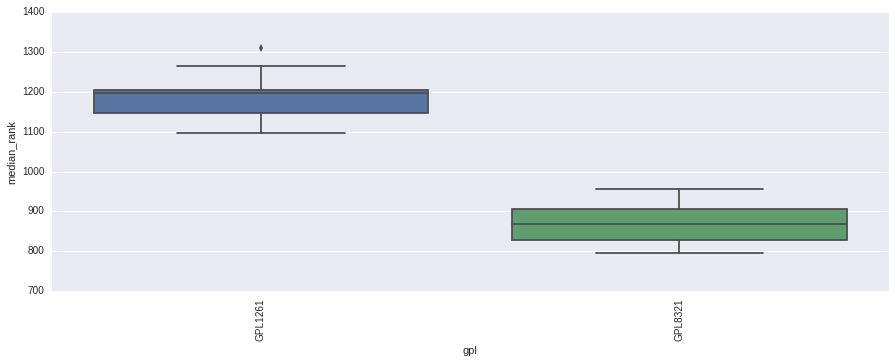

In [30]:
fig, ax = subplots(figsize=(15, 5))
sns.boxplot(data=res, x='gpl', y='median_rank', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical');

## Using all data
(not performed here due to time reasons)
![](result_all_platforms.png)